# № 2

A signal emitted by a source at an unknown position $r \in R^2$ is received by $m$ sensors at known positions $r_1, . . . , r_m \in R^2$. From the strength of the received signals, the noisy estimates $d_k$ of the distances $\Vert r-r_k \Vert_2$ are obtained. We are interested in estimating the source position $r$ based on the measured distances $d_k$. Formally, we have to minimize:
$$
L(r) = \sum_k \left(\Vert r - r_k\Vert_2^2 - d_k^2\right)^2
\tag{9}
$$
over $r$ at given $r_k$ and $d_k$.

### Part 1

Is the function in Eq. (4) convex?

Решение:

Рассмотрим случай одного сенсора:
$$
L(r) = \left(\Vert r - r_1\Vert_2^2 - d_k^2\right)^2
$$

Обозначим $\Vert r - r_1\Vert = x$ и построим график функции $L(x)$:

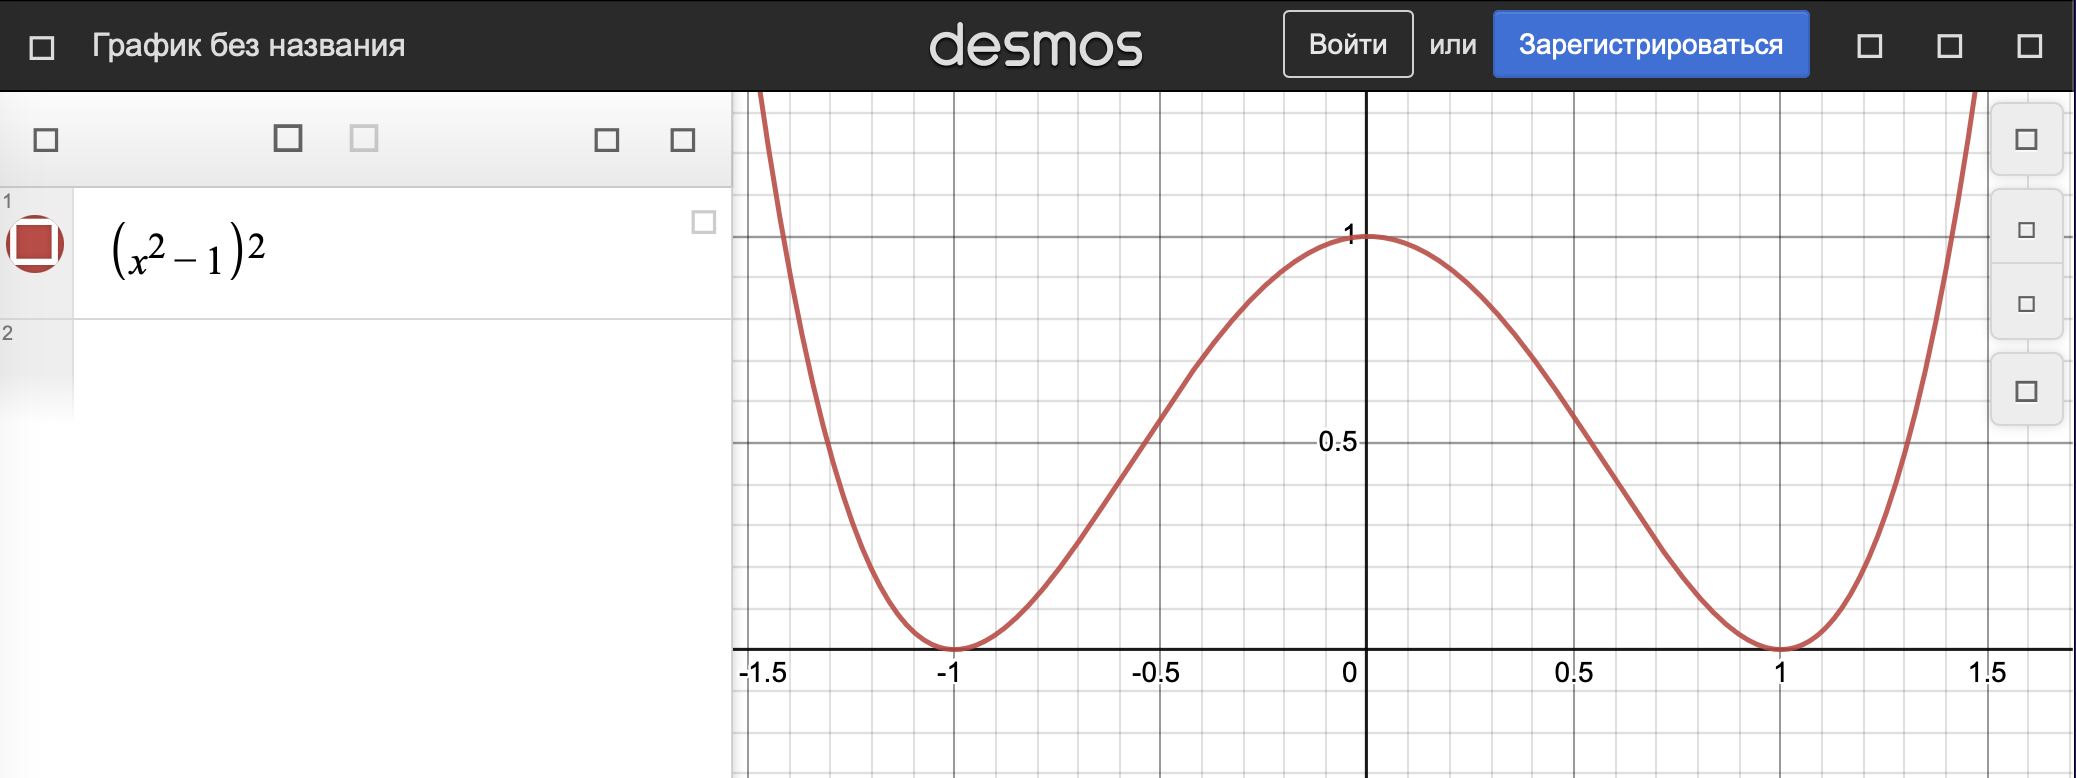

Видно, что функция не является выпуклой. Формально, мы должны были строить двумерный график $L(r)$. Он получается вращением одномерного графика $L(x)$ вокруг вертикальной оси. Он тоже не будет выпуклым.

### Part 2

Your goal in this task is to find the global minimum using the method of Lagrange multipliers. Consider rewriting the optimization problem identically to 
$$
\min_{r, t} \sum_k \left(t +\Vert r_k \Vert_2^2 - 2 r\cdot r_k- d_k^2\right)^2\quad\textrm{s.t.}\quad\Vert r\Vert_2^2=t
$$

This minimization under constraint is reduced to finding stationary points in $r=(x, y)$ and $t$ of the following Lagrangian

$$
\bar L(x, y, t) =  \sum_k \left(t +\Vert r_k \Vert_2^2 - 2 r\cdot r_k- d_k^2\right)^2+\lambda\left(\Vert r\Vert_2^2-t\right).
$$

Since this is just a quadratic form over $x, y, t$, the stationary point can be found explicitly as $x(\lambda), y(\lambda), t(\lambda)$ (express these functions in terms of $r_k$ and $d_k$). NB: `sympy` can be useful at some point.

Зададим переменные и лагранжиан:

In [1]:
import sympy

In [2]:
# Координаты источника
X, Y = sympy.symbols('X Y', real=True)

T = sympy.symbols('T', positive=True)
lamb = sympy.symbols('lambda', real=True)

In [3]:
# Число детекторов
N = sympy.symbols('N', integer=True, positive=True)

# Координаты детекторов
x = sympy.IndexedBase('x', real=True)
y = sympy.IndexedBase('y', real=True)

# Измеренные расстояния
d = sympy.IndexedBase('d', positive=True)

k = sympy.symbols('k', integer=True)

In [4]:
s = sympy.Sum(
    (T + x[k]**2 + y[k]**2 - 2 * (X*x[k] + Y*y[k]) - d[k]**2)**2,
    (k, 0, N-1)
)
Lagrangian = s + lamb * (X**2 + Y**2 - T)
Lagrangian

lambda*(-T + X**2 + Y**2) + Sum((T - 2*X*x[k] - 2*Y*y[k] - d[k]**2 + x[k]**2 + y[k]**2)**2, (k, 0, N - 1))

Попробуем решить систему
$$
\begin{cases}
\frac{\partial \bar L}{\partial x} = 0\\
\frac{\partial \bar L}{\partial y} = 0\\
\frac{\partial \bar L}{\partial t} = 0\\
\end{cases}
$$
и выразить $X, Y, T$ через $\lambda$; затем применим уравнение $\frac{\partial \bar L}{\partial \lambda} = 0$ и найдем $\lambda$.

In [5]:
# Производные по X, Y, t — линейные
Lagrangian.diff(X)

2*X*lambda + Sum(-4*(T - 2*X*x[k] - 2*Y*y[k] - d[k]**2 + x[k]**2 + y[k]**2)*x[k], (k, 0, N - 1))

In [6]:
# Следовательно, мы можем записать систему в виде матрицы

def factor_constants(expr):
    return sympy.factor_terms(expr.expand())

A, b = sympy.linear_eq_to_matrix([
    factor_constants(Lagrangian.diff(X)),
    factor_constants(Lagrangian.diff(Y)),
    factor_constants(Lagrangian.diff(T)),
], [X, Y, T])

In [7]:
A

Matrix([
[2*lambda + 8*Sum(x[k]**2, (k, 0, N - 1)),          8*Sum(x[k]*y[k], (k, 0, N - 1)), -4*Sum(x[k], (k, 0, N - 1))],
[         8*Sum(x[k]*y[k], (k, 0, N - 1)), 2*lambda + 8*Sum(y[k]**2, (k, 0, N - 1)), -4*Sum(y[k], (k, 0, N - 1))],
[             -4*Sum(x[k], (k, 0, N - 1)),              -4*Sum(y[k], (k, 0, N - 1)),     2*Sum(1, (k, 0, N - 1))]])

In [8]:
b

Matrix([
[-4*Sum(d[k]**2*x[k], (k, 0, N - 1)) + 4*Sum(x[k]*y[k]**2, (k, 0, N - 1)) + 4*Sum(x[k]**3, (k, 0, N - 1))],
[-4*Sum(d[k]**2*y[k], (k, 0, N - 1)) + 4*Sum(x[k]**2*y[k], (k, 0, N - 1)) + 4*Sum(y[k]**3, (k, 0, N - 1))],
[  lambda + 2*Sum(d[k]**2, (k, 0, N - 1)) - 2*Sum(x[k]**2, (k, 0, N - 1)) - 2*Sum(y[k]**2, (k, 0, N - 1))]])

Решить матрицу аналитически может быть сложно, поэтому решим ее численно.

In [9]:
import numpy as np

In [10]:
A_func = sympy.lambdify((lamb, x, y, d), A.subs(N, 5))
b_func = sympy.lambdify((lamb, x, y, d), b.subs(N, 5))

def X_Y_T(lamb, x, y, d):
    A_val = A_func(lamb, x, y, d)
    b_val = b_func(lamb, x, y, d)
    return np.linalg.solve(A_val, b_val)

In [11]:
positions = np.load("P.npy")
x_vals = positions[:, 0]
y_vals = positions[:, 1]

d_vals = np.load("D.npy")

In [12]:
X_Y_T(1, x_vals, y_vals, d_vals)

array([[ 9.563697  ],
       [ 2.04634211],
       [96.83254031]])

Мы выразили $X, Y, T$ через $\lambda$. Осталось подставить их в уравнение $\frac{\partial \bar L}{\partial \lambda} = X^2 + Y^2 - T = 0$ и численно решить полученное уравнение на $\lambda$.

In [13]:
def constraint(lamb, x, y, d):
    X_val, Y_val, T_val = X_Y_T(lamb, x, y, d).flatten()
    return X_val**2 + Y_val**2 - T_val

Прежде чем решать его, построим график:

In [14]:
import plotly.express as px

In [15]:
lambdas = np.linspace(-3000, 1000, 1000)
constraints = [constraint(lamb, x_vals, y_vals, d_vals) for lamb in lambdas]

In [16]:
px.line({"lambda": lambdas, "X^2 + Y^2 - T": constraints}, x="lambda", y="X^2 + Y^2 - T", template="plotly_dark").update_yaxes(range=[-500, 1000])

Как видно из графика, у уравнения есть только один корень. Найдем его.

In [17]:
from scipy.optimize import *

In [18]:
lamb_val = newton(constraint, args=(x_vals, y_vals, d_vals), x0=0)

lamb_val

-0.7108749802552808

В принципе, поскольку зависимости $X(\lambda),\ Y(\lambda),\ T(\lambda)$ — линейные, можно было аналитически найти производную выражения $x^2 + y^2 - t$ по $\lambda$, это позволило бы более эффективно искать численное решение. Но функция `scipy.optimize.newton` и так хорошо отработала.

In [127]:
# Итоговое оптимальное положение
XY_val = X_Y_T(lamb_val, x_vals, y_vals, d_vals)[:-1]
XY_val

array([[9.63212088],
       [2.03950827]])

### Part 3

Plot the graph with
1. positions of the detectors
2. contour lines of $L(r)$
3. all locally extremal points and
4. the global minimum. 

Characterize the locally extremal points (local maximum/minimum/saddle point).

In [26]:
def target_function(R, positions, distances):
    return np.sum((np.linalg.norm(positions - R, axis=1) - distances)**2)

In [27]:
target_function(XY_val.T, positions, d_vals)

0.0017459926871520248

In [141]:
x_list = np.linspace(-5, 10, 150)
y_list = np.linspace(-10, 10, 200)

In [148]:
z_list = np.array([
    [target_function([x, y], positions, d_vals) for x in x_list]
    for y in y_list]
)

In [149]:
import plotly.graph_objects as go

In [150]:
go.Figure(go.Surface(x=x_list, y=y_list,z=z_list)).update_layout(template="plotly_dark")

In [161]:
fig1 = go.Figure(go.Contour(x=x_list, y=y_list,z=z_list))

fig2 = px.scatter(x=positions[:, 0], y=positions[:, 1]).update_traces(marker_color="white")

fig3 = px.scatter(x=XY_val[0], y=XY_val[1]).update_traces(marker_color="red")

go.Figure(fig1.data + fig2.data + fig3.data).update_layout(template="plotly_dark", width=500, height=500)

Есть одна стационарная точка (отмечена красным), которая явялется глобальным минимумом.